In [ ]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline
import math
from IPython.display import display
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.datasets import make_imbalance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Seaborn version',sns.__version__)

Numpy version 1.21.6
Pandas version 1.3.5
Seaborn version 0.11.2


In [ ]:
# Heart Failure Prediction dataset
df_heart = pd.read_csv('heart.csv')

In [ ]:
# to display all columns in the dataset
pd.options.display.max_columns = None

In [ ]:
# Function to detect missing values and duplicate records

def missing_duplicates(col):
    if col.isnull().sum().sum() == 0:
        print('There are no missing values in the dataset')
    else:
        print('There are missing values in the dataset')
        
    count = 0
    for count in col.columns:
        if col[count].isnull().sum() != 0:
            print('There are {} missing values in the feature: '.format(col[count].isnull().sum()),count)
            print('Percentage of missing values in the feature:',round(col[count].isnull().sum()/col.shape[0] * 100,3),'%')
            print('Percentage of missing values in total data points:',round(col[count].isnull().sum()/(col.shape[0]*col.shape[1]) * 100,3),'%')
            
    if col.duplicated().sum() == 0:
        print('There are no duplicate records found in the dataset')
    else:
        print('There are duplicate rows found in the dataset.','\nTotal duplicate rows:', col.duplicated.sum())

In [ ]:
# Function to check balance of the target variable and countplot
def balance_ratio(col):
    print('Balance ratio of variable in Percentage')
    print(round(col.value_counts(normalize=True) * 100,2))
    print('')
    sns.countplot(col)
    plt.title('Count plot')
    plt.show()

In [ ]:
# Fuctions to plot the graphs for countplot, histograms and boxplot

# Function to plot the graph of countplots
def countplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(include=['object'])
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype == 'object':
            plt.subplot(a,b,c)
            sns.countplot(x=col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of Histograms
def histogram(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.distplot(col[i])
            c = c + 1
    plt.show()
    return

# Function to plot the graph of boxplots
def boxplots(col,figsize_len,figsize_wid,column):
    col = col.select_dtypes(exclude='object')
    plt.figure(figsize=(figsize_len,figsize_wid))
    a,b,c = math.ceil(col.shape[1]/column),column,1
    i = 0
    for i in col.columns:
        if col[i].dtype != 'object':
            plt.subplot(a,b,c)
            sns.boxplot(col[i])
            c = c + 1
    plt.show()
    return

In [ ]:
# Function to create data imbalance
def create_imbalance(df,target_index,Perc):
    data = df.copy()
    
    # seperating independent and dependent variables
    X = data.drop(data.columns[target_index],axis=1)
    y = data.iloc[:,target_index]
    
    # creating imbalance from given percentage
    ratio1 = int(y.value_counts().sort_values(ascending=False)[0] * (Perc/100))
    ratio2 = int(y.value_counts().sort_values(ascending=False)[0]) - ratio1
    label1 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[0]
    label2 = data.iloc[:,target_index].value_counts().sort_values(ascending=False).index[1]
    
    #making imbalance
    X_res, y_res = make_imbalance(X, y, sampling_strategy={label1:ratio1, label2:ratio2}, random_state=1)
    target_variable = data.columns[target_index]
    X_res[target_variable] = y_res
    
    return X_res

# Heart Failure Prediction dataset

In [ ]:
# now lets exlore the heart failure dataset

# checking the top 5 rows of the data
df_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# information of the data
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# describing the data
df_heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [ ]:
# Checking missing values and duplicates
missing_duplicates(df_heart)

There are no missing values in the dataset
There are no duplicate records found in the dataset


In [ ]:
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 0,'No','Yes')

Balance ratio of variable in Percentage
Yes    55.34
No     44.66
Name: HeartDisease, dtype: float64



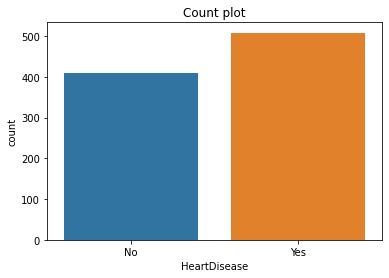

In [ ]:
# Checking the target feature balance
balance_ratio(df_heart['HeartDisease'])

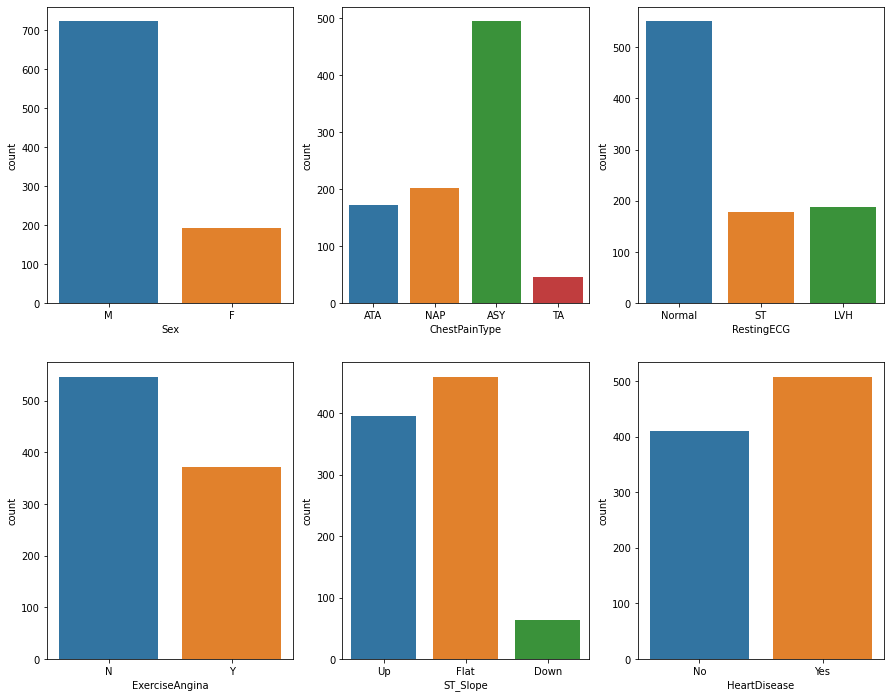

In [ ]:
# we will check countplots for categorical variables
countplots(df_heart,15,12,3)

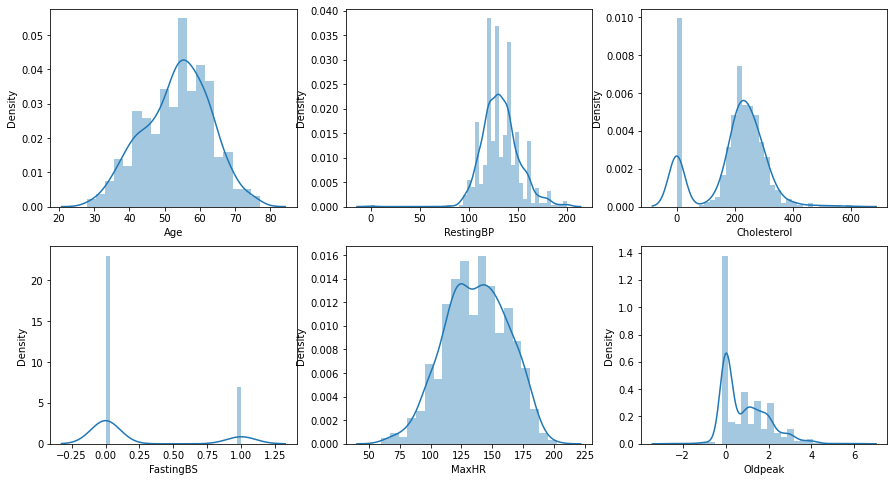

In [ ]:
histogram(df_heart,15,8,3)

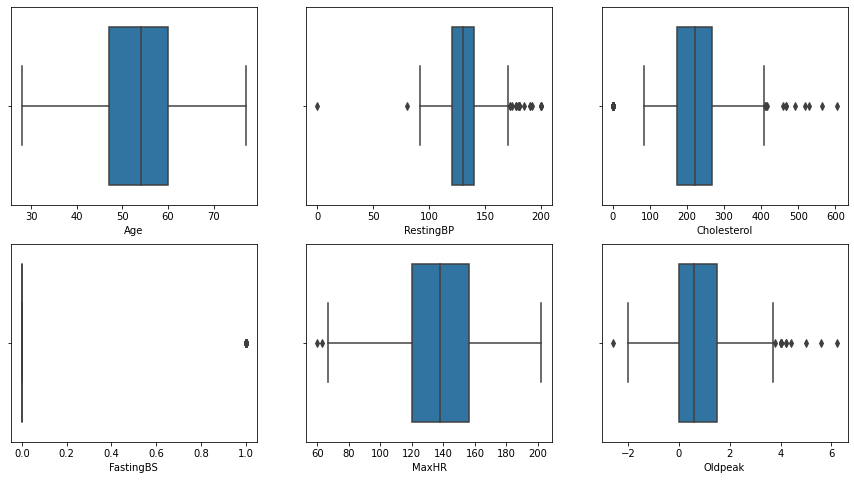

In [ ]:
boxplots(df_heart,15,8,3)

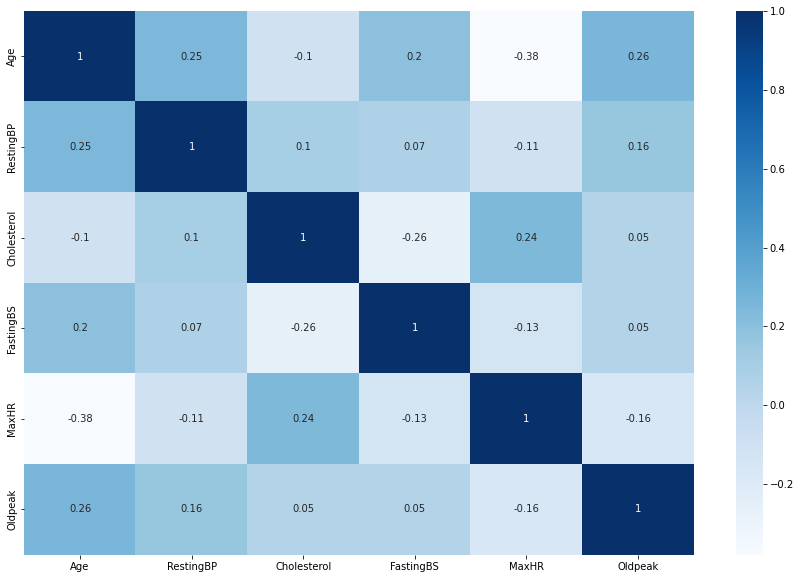

In [ ]:
#Bivariate Analysis using heatmap
plt.figure(figsize=(15,10))
sns.heatmap(round(df_heart.corr(),2),annot=True,cmap='Blues')
plt.show()

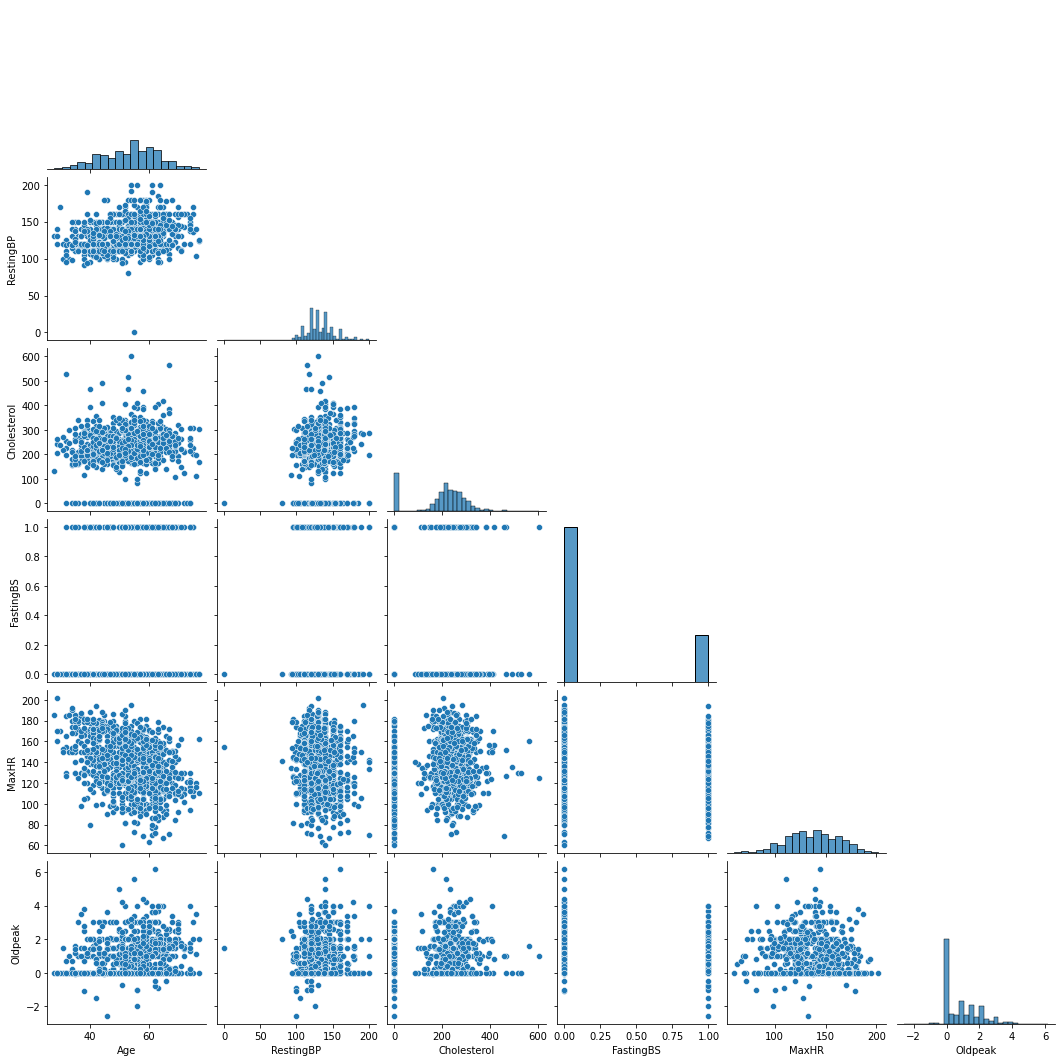

In [ ]:
# pairplot
sns.pairplot(df_heart, corner=True)

In [ ]:
df_heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [ ]:
# We will perform one hot encoding on all categorical variables.
# Drop_first is set to True in order to avoid multicolinearity and also it reduces number of features
# We will not encode the target variable i.e 'HeartDisease'
df_heart = pd.get_dummies(data=df_heart, columns=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], drop_first=True)
df_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,No,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,Yes,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,No,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,Yes,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,No,1,0,1,0,1,0,0,0,1


In [ ]:
df_heart.shape

(918, 16)

Balance ratio of variable in Percentage
Yes    64.96
No     35.04
Name: HeartDisease, dtype: float64



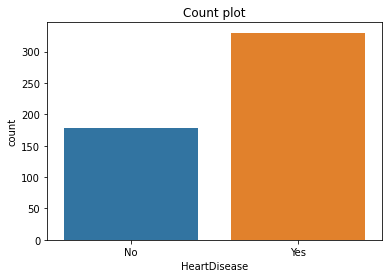

In [ ]:
# creating 65:35 imbalance ratio
df_heart_65 = create_imbalance(df_heart,6,65)
balance_ratio(df_heart_65['HeartDisease'])

Balance ratio of variable in Percentage
Yes    75.0
No     25.0
Name: HeartDisease, dtype: float64



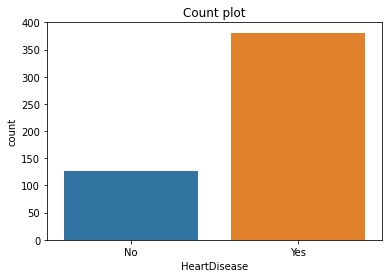

In [ ]:
# creating 75:25 imbalance ratio
df_heart_75 = create_imbalance(df_heart,6,75)
balance_ratio(df_heart_75['HeartDisease'])

Balance ratio of variable in Percentage
Yes    89.96
No     10.04
Name: HeartDisease, dtype: float64



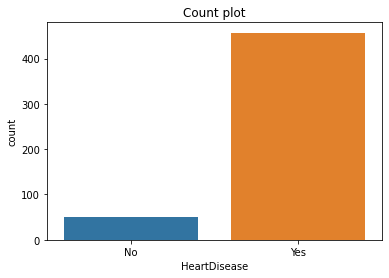

In [ ]:
# creating 90:10 imbalance ratio
df_heart_90 = create_imbalance(df_heart,6,90)
balance_ratio(df_heart_90['HeartDisease'])

**Base Line Model**

In [ ]:
# grid search to find best hyper tuning parameters

# configuring min max sacling
scale_minmax = MinMaxScaler()

# seperating target and features
X = df_heart.drop(columns=['HeartDisease'],axis=1)
y = df_heart['HeartDisease']

X = pd.DataFrame(scale_minmax.fit_transform(X), columns=X.columns)


grid = {
    'max_features': [4,5],
    'max_depth': [4,5,6],
    'min_samples_leaf': [5,10], 
    'min_samples_split': [2,4,6],
       }

RF_Model = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator = RF_Model, param_grid = grid, cv = 10,n_jobs=-1,scoring='f1')
grid_search.fit(X, y)
print(grid_search.best_params_,'\n')

{'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 5, 'min_samples_split': 2} 



In [ ]:
# configuring stratified cross validation with cv=10
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# configuring scaling
scale = MinMaxScaler()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.85254 +/- 0.00676
Test F1 score after 10 fold CV: 0.82829 +/- 0.06941
Train kappa after 10 fold CV: 0.74375 +/- 0.01143
Test Kappa after 10 fold CV: 0.70755 +/- 0.10788
Train Accuracy after 10 fold CV: 0.87449 +/- 0.00557
Test Accuracy after 10 fold CV: 0.85733 +/- 0.05156



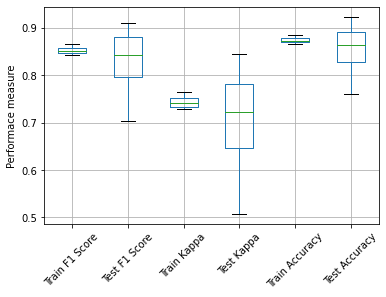

In [ ]:
# for original data

# seperating target and features
X = df_heart.drop(columns=['HeartDisease'],axis=1)
y = df_heart['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='No')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='No')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_original = train_acc
test_acc_BL_original = test_acc
train_f1_BL_original = train_f1
test_f1_BL_original = test_f1
train_kappa_BL_original = train_kappa
test_kappa_BL_original = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.85907 +/- 0.01013
Test F1 score after 10 fold CV: 0.82298 +/- 0.05819
Train kappa after 10 fold CV: 0.78768 +/- 0.015
Test Kappa after 10 fold CV: 0.73466 +/- 0.08163
Train Accuracy after 10 fold CV: 0.90508 +/- 0.00664
Test Accuracy after 10 fold CV: 0.88176 +/- 0.0345



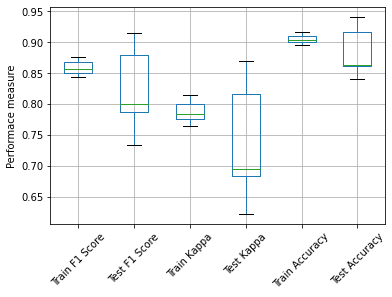

In [ ]:
# for low imbalance data

# seperating target and features
X = df_heart_65.drop(columns=['HeartDisease'],axis=1)
y = df_heart_65['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='No')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='No')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_low = train_acc
test_acc_BL_low = test_acc
train_f1_BL_low = train_f1
test_f1_BL_low = test_f1
train_kappa_BL_low = train_kappa
test_kappa_BL_low = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.84014 +/- 0.00733
Test F1 score after 10 fold CV: 0.78186 +/- 0.08238
Train kappa after 10 fold CV: 0.78953 +/- 0.00957
Test Kappa after 10 fold CV: 0.71422 +/- 0.1082
Train Accuracy after 10 fold CV: 0.92301 +/- 0.0035
Test Accuracy after 10 fold CV: 0.89565 +/- 0.04124



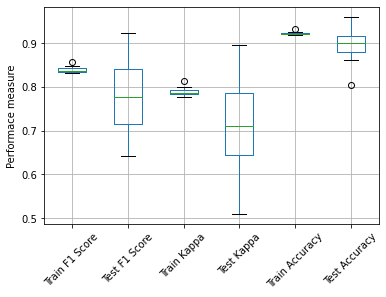

In [ ]:
# for med imbalance data

# seperating target and features
X = df_heart_75.drop(columns=['HeartDisease'],axis=1)
y = df_heart_75['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='No')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='No')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_med = train_acc
test_acc_BL_med = test_acc
train_f1_BL_med = train_f1
test_f1_BL_med = test_f1
train_kappa_BL_med = train_kappa
test_kappa_BL_med = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10

Train F1 score after 10 fold CV: 0.59299 +/- 0.04204
Test F1 score after 10 fold CV: 0.43611 +/- 0.24774
Train kappa after 10 fold CV: 0.56479 +/- 0.04333
Test Kappa after 10 fold CV: 0.41015 +/- 0.2402
Train Accuracy after 10 fold CV: 0.93963 +/- 0.00471
Test Accuracy after 10 fold CV: 0.9251 +/- 0.02157



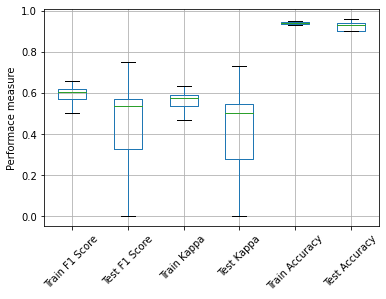

In [ ]:
# for high imbalance data

# seperating target and features
X = df_heart_90.drop(columns=['HeartDisease'],axis=1)
y = df_heart_90['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
train_f1 = []
test_f1 = []
train_kappa = []
test_kappa = []
train_acc = []
test_acc = []
for train_index, test_index in skf.split(X, y):
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  x_train_fold_scale = pd.DataFrame(scale.fit_transform(x_train_fold), columns=x_train_fold.columns)
  x_test_fold_scale = pd.DataFrame(scale.transform(x_test_fold), columns=x_test_fold.columns)
  BL_Model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
  BL_Model.fit(x_train_fold_scale, y_train_fold)
  train_f1_cv = metrics.f1_score(y_train_fold, BL_Model.predict(x_train_fold_scale), pos_label='No')
  test_f1_cv = metrics.f1_score(y_test_fold, BL_Model.predict(x_test_fold_scale), pos_label='No')
  train_kappa_cv = metrics.cohen_kappa_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_kappa_cv = metrics.cohen_kappa_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  train_acc_cv = metrics.accuracy_score(y_train_fold, BL_Model.predict(x_train_fold_scale))#, pos_label='Yes')
  test_acc_cv = metrics.accuracy_score(y_test_fold, BL_Model.predict(x_test_fold_scale))#, pos_label='Yes')
  print('Iteration number:', iteration_no)
  train_f1 = np.append(train_f1, train_f1_cv)
  test_f1 = np.append(test_f1, test_f1_cv)
  train_kappa = np.append(train_kappa, train_kappa_cv)
  test_kappa = np.append(test_kappa, test_kappa_cv)
  train_acc = np.append(train_acc, train_acc_cv)
  test_acc = np.append(test_acc, test_acc_cv)
  iteration_no += 1
print('\nTrain F1 score after 10 fold CV:', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Test F1 score after 10 fold CV:', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
print('Train kappa after 10 fold CV:', round(train_kappa.mean(),5),'+/-', round(train_kappa.std(),5))
print('Test Kappa after 10 fold CV:', round(test_kappa.mean(),5),'+/-', round(test_kappa.std(),5))
print('Train Accuracy after 10 fold CV:', round(train_acc.mean(),5),'+/-', round(train_acc.std(),5))
print('Test Accuracy after 10 fold CV:', round(test_acc.mean(),5),'+/-', round(test_acc.std(),5))
print('')

# saving performance metrics for comparison
train_acc_BL_hig = train_acc
test_acc_BL_hig = test_acc
train_f1_BL_hig = train_f1
test_f1_BL_hig = test_f1
train_kappa_BL_hig = train_kappa
test_kappa_BL_hig = test_kappa

# visualising the performace metrics
visualise = {'Train F1 Score': train_f1, 'Test F1 Score': test_f1,
             'Train Kappa': train_kappa, 'Test Kappa': test_kappa,
             'Train Accuracy': train_acc, 'Test Accuracy': test_acc}
visualise = pd.DataFrame(visualise)
visualise.boxplot()
plt.ylabel('Performace measure')
plt.xticks(rotation=45)
plt.show()

**K-means clustering for original data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 'No', 0, df_heart['HeartDisease'])
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 'Yes', 1, df_heart['HeartDisease'])

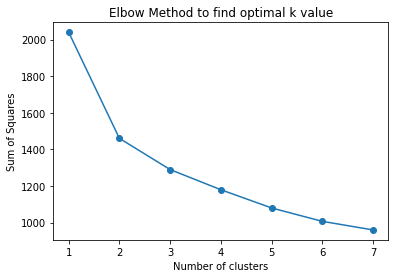

In [ ]:
# checking optimal value of k using elbow method
df_heart_scale = pd.DataFrame(scale_minmax.fit_transform(df_heart), columns=df_heart.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_heart_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


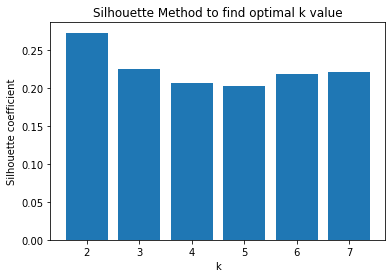

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_heart_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_heart_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 0, 'No', df_heart['HeartDisease'])
df_heart['HeartDisease'] = np.where(df_heart['HeartDisease'] == 1, 'Yes', df_heart['HeartDisease'])

In [ ]:
# for original data

# seperating target and features
X = df_heart.drop(columns=['HeartDisease'],axis=1)
y = df_heart['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_org = train_f1
test_f1_cluster0_org = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27441
Minority class samples: 122
Train F1 0.33113
Test F1 0.19048
**********Iteration Number 2**********
Silhouette score: 0.27593
Minority class samples: 67
Train F1 0.11268
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27101
Minority class samples: 72
Train F1 0.17500
Test F1 0.09091
**********Iteration Number 4**********
Silhouette score: 0.27558
Minority class samples: 71
Train F1 0.10667
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.27909
Minority class samples: 61
Train F1 0.06349
Test F1 0.00000
**********Iteration Number 6**********
Silhouette score: 0.26813
Minority class samples: 98
Train F1 0.11538
Test F1 0.17391
**********Iteration Number 7**********
Silhouette score: 0.27452
Minority class samples: 67
Train F1 0.13889
Test F1 0.08333
**********Iteration Number 8**********
Silhouette score: 0.27267
Minority class samples: 73
Train F1 0.10390
Test F1 0.00000

In [ ]:
# for original data

# seperating target and features
X = df_heart.drop(columns=['HeartDisease'],axis=1)
y = df_heart['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_org = train_f1
test_f1_cluster1_org = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27441
Minority class samples: 122
Train F1 0.82435
Test F1 0.19048
**********Iteration Number 2**********
Silhouette score: 0.27593
Minority class samples: 67
Train F1 0.92800
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27101
Minority class samples: 72
Train F1 0.92124
Test F1 0.09091
**********Iteration Number 4**********
Silhouette score: 0.27558
Minority class samples: 71
Train F1 0.92033
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.27909
Minority class samples: 61
Train F1 0.93273
Test F1 0.00000
**********Iteration Number 6**********
Silhouette score: 0.26813
Minority class samples: 98
Train F1 0.85535
Test F1 0.17391
**********Iteration Number 7**********
Silhouette score: 0.27452
Minority class samples: 67
Train F1 0.93018
Test F1 0.08333
**********Iteration Number 8**********
Silhouette score: 0.27267
Minority class samples: 73
Train F1 0.92203
Test F1 0.00000

**K-means clustering for low imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_heart_65['HeartDisease'] = np.where(df_heart_65['HeartDisease'] == 'No', 0, df_heart_65['HeartDisease'])
df_heart_65['HeartDisease'] = np.where(df_heart_65['HeartDisease'] == 'Yes', 1, df_heart_65['HeartDisease'])

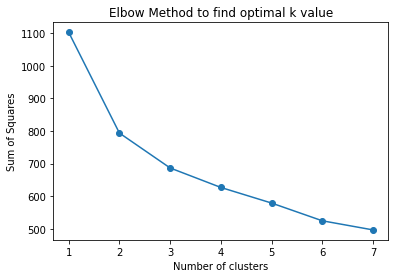

In [ ]:
# checking optimal value of k using elbow method
df_heart_scale = pd.DataFrame(scale_minmax.fit_transform(df_heart_65), columns=df_heart_65.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_heart_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


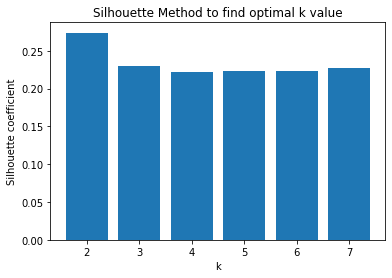

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_heart_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_heart_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_heart_65['HeartDisease'] = np.where(df_heart_65['HeartDisease'] == 0, 'No', df_heart_65['HeartDisease'])
df_heart_65['HeartDisease'] = np.where(df_heart_65['HeartDisease'] == 1, 'Yes', df_heart_65['HeartDisease'])

In [ ]:
# for low imbalance data

# seperating target and features
X = df_heart_65.drop(columns=['HeartDisease'],axis=1)
y = df_heart_65['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_65.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_65.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_low = train_f1
test_f1_cluster0_low = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27207
Minority class samples: 39
Train F1 0.93238
Test F1 0.65455
**********Iteration Number 2**********
Silhouette score: 0.28071
Minority class samples: 35
Train F1 0.92667
Test F1 0.63158
**********Iteration Number 3**********
Silhouette score: 0.27095
Minority class samples: 25
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 4**********
Silhouette score: 0.27768
Minority class samples: 44
Train F1 0.93662
Test F1 0.68182
**********Iteration Number 5**********
Silhouette score: 0.27836
Minority class samples: 30
Train F1 0.92557
Test F1 0.63158
**********Iteration Number 6**********
Silhouette score: 0.26986
Minority class samples: 26
Train F1 0.20690
Test F1 0.00000
**********Iteration Number 7**********
Silhouette score: 0.27061
Minority class samples: 53
Train F1 0.92527
Test F1 0.81818
**********Iteration Number 8**********
Silhouette score: 0.27232
Minority class samples: 48
Train F1 0.94928
Test F1 0.72340


In [ ]:
# for low imbalance data

# seperating target and features
X = df_heart_65.drop(columns=['HeartDisease'],axis=1)
y = df_heart_65['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_65.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_65.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_low = train_f1
test_f1_cluster1_low = test_f1

**********Iteration Number 1**********
Silhouette score: 0.27207
Minority class samples: 27
Train F1 0.25806
Test F1 0.10000
**********Iteration Number 2**********
Silhouette score: 0.28071
Minority class samples: 19
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27095
Minority class samples: 49
Train F1 0.93286
Test F1 0.73913
**********Iteration Number 4**********
Silhouette score: 0.27768
Minority class samples: 24
Train F1 0.15385
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.27836
Minority class samples: 15
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 6**********
Silhouette score: 0.26986
Minority class samples: 49
Train F1 0.93950
Test F1 0.72340
**********Iteration Number 7**********
Silhouette score: 0.27061
Minority class samples: 27
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 8**********
Silhouette score: 0.27232
Minority class samples: 28
Train F1 0.24242
Test F1 0.00000


**K-means clustering for med imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable, 1 for satisfied and 0 for other
df_heart_75['HeartDisease'] = np.where(df_heart_75['HeartDisease'] == 'No', 0, df_heart_75['HeartDisease'])
df_heart_75['HeartDisease'] = np.where(df_heart_75['HeartDisease'] == 'Yes', 1, df_heart_75['HeartDisease'])

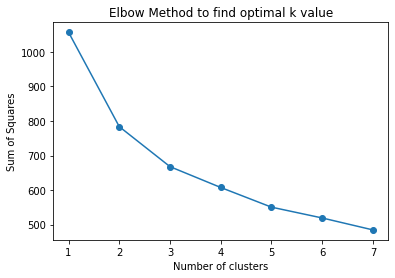

In [ ]:
# checking optimal value of k using elbow method
df_heart_scale = pd.DataFrame(scale_minmax.fit_transform(df_heart_75), columns=df_heart_75.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_heart_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


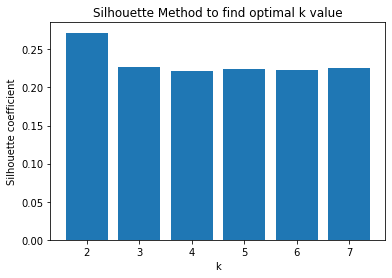

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_heart_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_heart_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_heart_75['HeartDisease'] = np.where(df_heart_75['HeartDisease'] == 0, 'No', df_heart_75['HeartDisease'])
df_heart_75['HeartDisease'] = np.where(df_heart_75['HeartDisease'] == 1, 'Yes', df_heart_75['HeartDisease'])

In [ ]:
# for med imbalance data

# seperating target and features
X = df_heart_75.drop(columns=['HeartDisease'],axis=1)
y = df_heart_75['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_75.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_75.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_med = train_f1
test_f1_cluster0_med = test_f1

**********Iteration Number 1**********
Silhouette score: 0.26825
Minority class samples: 58
Train F1 0.94175
Test F1 0.64516
**********Iteration Number 2**********
Silhouette score: 0.27533
Minority class samples: 55
Train F1 0.93137
Test F1 0.68750
**********Iteration Number 3**********
Silhouette score: 0.27413
Minority class samples: 59
Train F1 0.92754
Test F1 0.77419
**********Iteration Number 4**********
Silhouette score: 0.27332
Minority class samples: 53
Train F1 0.95431
Test F1 0.51429
**********Iteration Number 5**********
Silhouette score: 0.26359
Minority class samples: 58
Train F1 0.93069
Test F1 0.72727
**********Iteration Number 6**********
Silhouette score: 0.27187
Minority class samples: 58
Train F1 0.93137
Test F1 0.74286
**********Iteration Number 7**********
Silhouette score: 0.27379
Minority class samples: 51
Train F1 0.91707
Test F1 0.65000
**********Iteration Number 8**********
Silhouette score: 0.2705
Minority class samples: 52
Train F1 0.94059
Test F1 0.68750
*

In [ ]:
# for med imbalance data

# seperating target and features
X = df_heart_75.drop(columns=['HeartDisease'],axis=1)
y = df_heart_75['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_75.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 1]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_75.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_med = train_f1
test_f1_cluster1_med = test_f1

**********Iteration Number 1**********
Silhouette score: 0.26825
Minority class samples: 16
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 2**********
Silhouette score: 0.27533
Minority class samples: 17
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 3**********
Silhouette score: 0.27413
Minority class samples: 16
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 4**********
Silhouette score: 0.27332
Minority class samples: 18
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 5**********
Silhouette score: 0.26359
Minority class samples: 20
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 6**********
Silhouette score: 0.27187
Minority class samples: 18
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 7**********
Silhouette score: 0.27379
Minority class samples: 19
Train F1 0.00000
Test F1 0.00000
**********Iteration Number 8**********
Silhouette score: 0.2705
Minority class samples: 19
Train F1 0.00000
Test F1 0.00000
*

**K-means clustering for high imbalance data**

In [ ]:
# configuring min max sacling
scale_minmax = MinMaxScaler()

# Encoding target variable
df_heart_90['HeartDisease'] = np.where(df_heart_90['HeartDisease'] == 'No', 0, df_heart_90['HeartDisease'])
df_heart_90['HeartDisease'] = np.where(df_heart_90['HeartDisease'] == 'Yes', 1, df_heart_90['HeartDisease'])

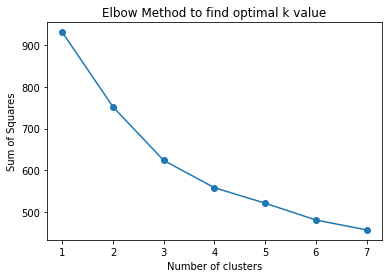

In [ ]:
# checking optimal value of k using elbow method
df_heart_scale = pd.DataFrame(scale_minmax.fit_transform(df_heart_90), columns=df_heart_90.columns)

# running k-means to find optimum k value

WSS = [] # creating empty list for appending Within sum of squares
K = range(1,8)
for k in K:
    k_means = KMeans(n_clusters=k,random_state=1)
    K_means_model = k_means.fit(df_heart_scale)
    WSS.append(K_means_model.inertia_)
plt.plot(K, WSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squares')
plt.title('Elbow Method to find optimal k value')
plt.show()

2
3
4
5
6
7


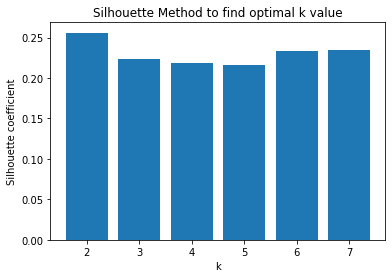

In [ ]:
# checking optimal value of k using silhoutte method
K = range(2,8)
No_of_clusters = []
Silhouette_scores = []

for k in K:
  k_means = KMeans(n_clusters=k,random_state=1)
  k_means.fit(df_heart_scale)
  preds = k_means.labels_
  centers = k_means.cluster_centers_
  sil_score = silhouette_score(df_heart_scale,preds)
  No_of_clusters.append(k)
  Silhouette_scores.append(sil_score)
  print(k)

plt.xlabel('k')
plt.ylabel('Silhouette coefficient')
plt.title('Silhouette Method to find optimal k value')
plt.bar(No_of_clusters,Silhouette_scores)
plt.show()

In [ ]:
df_heart_90['HeartDisease'] = np.where(df_heart_90['HeartDisease'] == 0, 'No', df_heart_90['HeartDisease'])
df_heart_90['HeartDisease'] = np.where(df_heart_90['HeartDisease'] == 1, 'Yes', df_heart_90['HeartDisease'])

In [ ]:
# for high imbalance data

# seperating target and features
X = df_heart_90.drop(columns=['HeartDisease'],axis=1)
y = df_heart_90['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_90.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 0
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=0)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_90.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster0_hig = train_f1
test_f1_cluster0_hig = test_f1

**********Iteration Number 1**********
Silhouette score: 0.25221
Minority class samples: 33
Train F1 0.79365
Test F1 0.72727
**********Iteration Number 2**********
Silhouette score: 0.25565
Minority class samples: 35
Train F1 0.75410
Test F1 0.60000
**********Iteration Number 3**********
Silhouette score: 0.25558
Minority class samples: 36
Train F1 0.77612
Test F1 0.66667
**********Iteration Number 4**********
Silhouette score: 0.25108
Minority class samples: 34
Train F1 0.80000
Test F1 0.40000
**********Iteration Number 5**********
Silhouette score: 0.24898
Minority class samples: 35
Train F1 0.83077
Test F1 0.40000
**********Iteration Number 6**********
Silhouette score: 0.25901
Minority class samples: 36
Train F1 0.76190
Test F1 0.46154
**********Iteration Number 7**********
Silhouette score: 0.25381
Minority class samples: 34
Train F1 0.83871
Test F1 0.66667
**********Iteration Number 8**********
Silhouette score: 0.26068
Minority class samples: 36
Train F1 0.80597
Test F1 0.60000


In [ ]:
# for high imbalance data

# seperating target and features
X = df_heart_90.drop(columns=['HeartDisease'],axis=1)
y = df_heart_90['HeartDisease']

# performing 10 fold stratified cross validation
iteration_no = 1
minority_class_samples_save = []
centers_save = []
train_f1 = []
test_f1 = []
Silhouette_scores = []
for train_index, test_index in skf.split(X, y):
  print('**********Iteration Number {}**********'.format(iteration_no))
  x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
  y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
  df_train = x_train_fold.copy()
  test_data = x_test_fold.copy()
  test_data['HeartDisease'] = y_test_fold 
  df_train['HeartDisease'] = y_train_fold
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'No', 0, df_train['HeartDisease'])
  df_train['HeartDisease'] = np.where(df_train['HeartDisease'] == 'Yes', 1, df_train['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'No', 0, test_data['HeartDisease'])
  test_data['HeartDisease'] = np.where(test_data['HeartDisease'] == 'Yes', 1, test_data['HeartDisease'])

  df_train_scale = pd.DataFrame(scale_minmax.fit_transform(df_train), columns = df_heart_90.columns) 
  km_3 = KMeans(n_clusters=2,random_state=1)    # k=2 clusters using elbow and silhouette method
  km_3.fit(df_train_scale)
  centers = km_3.cluster_centers_
  centers_save = np.append(centers_save, centers)
  Cluster_3 = km_3.labels_
  sil_score = silhouette_score(df_train_scale,Cluster_3)
  print('Silhouette score:', round(sil_score,5))
  Silhouette_scores.append(sil_score)
  df_heart_cluster = df_train_scale.copy()
  df_heart_cluster['Cluster'] = Cluster_3

  # for cluster label 1
  df_cluster0 = df_heart_cluster[df_heart_cluster['Cluster'] == 0]
  minority_class_samples = df_cluster0.HeartDisease.value_counts().min()
  minority_class_samples_save = np.append(minority_class_samples_save, minority_class_samples)
  print('Minority class samples:',minority_class_samples)

  if minority_class_samples != 0:
    features = df_cluster0.drop(columns=['HeartDisease'], axis=1)
    labels = df_cluster0['HeartDisease']
    rf_model = RandomForestClassifier(n_estimators=100, max_features=4, max_depth=4, min_samples_leaf=5, min_samples_split=2, random_state=1)
    rf_model.fit(features, labels)
    #print('Train Data')
    train_f1_cv = metrics.f1_score(labels, rf_model.predict(features), pos_label=1)
    print('Train F1 {:.5f}'.format(train_f1_cv))
    train_f1 = np.append(train_f1, train_f1_cv)
    #print(metrics.classification_report(labels, rf_model.predict(features)))
  else:
    print('There are no samples of both classes, Hence classifier is not trained')

  test_data_scale = pd.DataFrame(scale_minmax.transform(test_data), columns = df_heart_90.columns)
  cluster_test_labels = km_3.fit_predict(test_data_scale)
  test_data_scale['Cluster'] = cluster_test_labels

  if minority_class_samples != 0:
    X_test = test_data_scale.drop(columns=['HeartDisease'], axis=1)
    y_test = test_data_scale['HeartDisease']
    #print('\nTest data')
    test_f1_cv = metrics.f1_score(y_test, rf_model.predict(X_test), pos_label=0)
    print('Test F1 {:.5f}'.format(test_f1_cv))
    test_f1 = np.append(test_f1, test_f1_cv)
    #print(metrics.classification_report(y_test, rf_model.predict(X_test)))
  else:
    print('There are no samples of both classes')
  iteration_no += 1
print('\nMinority class samples during each iterations', minority_class_samples_save)
print('Silhouette scores', round(np.mean(Silhouette_scores),5),'+/-', round(np.std(Silhouette_scores),5))
print('Overall train F1 score', round(train_f1.mean(),5),'+/-', round(train_f1.std(),5))
print('Overall test F1 score', round(test_f1.mean(),5),'+/-', round(test_f1.std(),5))
train_f1_cluster1_hig = train_f1
test_f1_cluster1_hig = test_f1

**********Iteration Number 1**********
Silhouette score: 0.25221
Minority class samples: 33
Train F1 0.91034
Test F1 0.72727
**********Iteration Number 2**********
Silhouette score: 0.25565
Minority class samples: 35
Train F1 0.89933
Test F1 0.60000
**********Iteration Number 3**********
Silhouette score: 0.25558
Minority class samples: 36
Train F1 0.89051
Test F1 0.66667
**********Iteration Number 4**********
Silhouette score: 0.25108
Minority class samples: 34
Train F1 0.92405
Test F1 0.40000
**********Iteration Number 5**********
Silhouette score: 0.24898
Minority class samples: 35
Train F1 0.92715
Test F1 0.40000
**********Iteration Number 6**********
Silhouette score: 0.25901
Minority class samples: 36
Train F1 0.90323
Test F1 0.46154
**********Iteration Number 7**********
Silhouette score: 0.25381
Minority class samples: 34
Train F1 0.93506
Test F1 0.66667
**********Iteration Number 8**********
Silhouette score: 0.26068
Minority class samples: 36
Train F1 0.91275
Test F1 0.60000


**Comparison using permutation test**

In [ ]:
from numpy.random.mtrand import permutation
def get_pvalue(iterations,Results1,Results2,diff):
  concat = np.concatenate((Results1,Results2))
  count = 0
  for i in range(0,iterations):
    permutation = np.random.permutation(concat)
    p_current = permutation[:len(Results1)]
    p_new = permutation[len(Results1):]
    mean_permutation_current = p_current.mean()
    mean_permutation_new = p_new.mean()
    t_permutation = mean_permutation_new - mean_permutation_current

    if(t_permutation > diff):
      count += 1
  p_value = count / iterations
  if p_value > 0.05:
    print('Since p value {} is greater than 0.05 we failed to reject null hypothesis'.format(round(p_value,4)))
    #print('Results 1 are not better than Results 2')
  else:
    print('Since p value {} is less than 0.05 we will reject null hypothesis'.format(round(p_value,4)))
    #print('Results 1 are better than Results 2')
  return #p_value

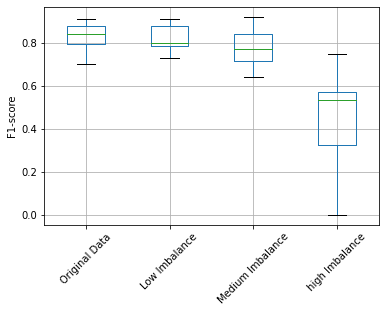

In [ ]:
# comaprison of baseline model for different imbalances
comparison = pd.concat([pd.Series(test_f1_BL_original), pd.Series(test_f1_BL_low), pd.Series(test_f1_BL_med), pd.Series(test_f1_BL_hig)], axis=1)
comparison.columns = ['Original Data', 'Low Imbalance', 'Medium Imbalance', 'high Imbalance']
comparison.boxplot()
plt.ylabel('F1-score')
plt.xticks(rotation=45)
plt.show()

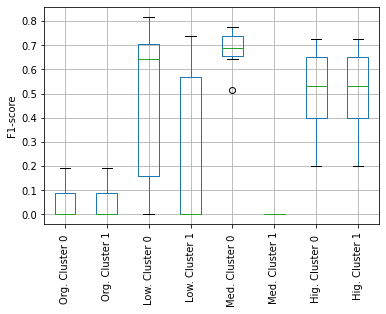

In [ ]:
# comaprison of custom model for different imbalances
comparison1 = pd.concat([pd.Series(test_f1_cluster0_org), pd.Series(test_f1_cluster1_org), pd.Series(test_f1_cluster0_low), pd.Series(test_f1_cluster1_low), pd.Series(test_f1_cluster0_med), pd.Series(test_f1_cluster1_med), pd.Series(test_f1_cluster0_hig), pd.Series(test_f1_cluster1_hig)], axis=1)
comparison1.columns = ['Org. Cluster 0 ', 'Org. Cluster 1', 'Low. Cluster 0 ', 'Low. Cluster 1', 'Med. Cluster 0 ', 'Med. Cluster 1', 'Hig. Cluster 0 ', 'Hig. Cluster 1']
comparison1.boxplot()
plt.ylabel('F1-score')
plt.xticks(rotation=90)
plt.show()

In [ ]:
comparison

,Original Data,Low Imbalance,Medium Imbalance,high Imbalance
0,0.820513,0.871795,0.695652,0.666667
1,0.702703,0.882353,0.769231,0.571429
2,0.871795,0.787879,0.761905,0.500000
3,0.800000,0.764706,0.642857,0.571429
4,0.724638,0.787879,0.923077,0.444444
5,0.909091,0.810811,0.869565,0.571429
6,0.883721,0.914286,0.827586,0.750000
7,0.864198,0.888889,0.846154,0.285714
8,0.794872,0.733333,0.782609,0.000000
9,0.911392,0.787879,0.700000,0.000000


In [ ]:
comparison1

,Org. Cluster 0,Org. Cluster 1,Low. Cluster 0,Low. Cluster 1,Med. Cluster 0,Med. Cluster 1,Hig. Cluster 0,Hig. Cluster 1
0,0.190476,0.190476,0.654545,0.100000,0.645161,0.0,0.727273,0.727273
1,0.000000,0.000000,0.631579,0.000000,0.687500,0.0,0.600000,0.600000
2,0.090909,0.090909,0.000000,0.739130,0.774194,0.0,0.666667,0.666667
3,0.000000,0.000000,0.681818,0.000000,0.514286,0.0,0.400000,0.400000
4,0.000000,0.000000,0.631579,0.000000,0.727273,0.0,0.400000,0.400000
5,0.173913,0.173913,0.000000,0.723404,0.742857,0.0,0.461538,0.461538
6,0.083333,0.083333,0.818182,0.000000,0.650000,0.0,0.666667,0.666667
7,0.000000,0.000000,0.723404,0.000000,0.687500,0.0,0.600000,0.600000
8,0.000000,0.000000,0.714286,0.000000,0.666667,0.0,0.200000,0.200000
9,0.000000,0.000000,0.000000,0.723404,0.740741,0.0,0.285714,0.285714


**Comparison between base and custom models**

In [ ]:
# original data comparison base line Vs custo model
diff = test_f1_BL_original.mean() - test_f1_cluster0_org.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_original, test_f1_cluster0_org, diff)

diff = test_f1_BL_original.mean() - test_f1_cluster1_org.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_original, test_f1_cluster1_org, diff)

Since p value 0.0 is less than 0.05 we will reject null hypothesis
Since p value 0.0 is less than 0.05 we will reject null hypothesis


In [ ]:
# low data imbalance comparison base line Vs custo model
diff = test_f1_BL_low.mean() - test_f1_cluster0_low.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_low, test_f1_cluster0_low, diff)

diff = test_f1_BL_low.mean() - test_f1_cluster1_low.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_low, test_f1_cluster1_low, diff)

Since p value 0.0003 is less than 0.05 we will reject null hypothesis
Since p value 0.0 is less than 0.05 we will reject null hypothesis


In [ ]:
# Medium data imbalance comparison base line Vs custo model
diff = test_f1_BL_med.mean() - test_f1_cluster0_med.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_med, test_f1_cluster0_med, diff)

diff = test_f1_BL_med.mean() - test_f1_cluster1_med.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_med, test_f1_cluster1_med, diff)

Since p value 0.008 is less than 0.05 we will reject null hypothesis
Since p value 0.0 is less than 0.05 we will reject null hypothesis


In [ ]:
# High data imbalance comparison base line Vs custo model
diff = test_f1_BL_hig.mean() - test_f1_cluster0_hig.mean()    #for cluster 0
get_pvalue(10000, test_f1_BL_hig, test_f1_cluster0_hig, diff)

diff = test_f1_BL_hig.mean() - test_f1_cluster1_hig.mean()    #for cluster 1
get_pvalue(10000, test_f1_BL_hig, test_f1_cluster1_hig, diff)

Since p value 0.7372 is greater than 0.05 we failed to reject null hypothesis
Since p value 0.7385 is greater than 0.05 we failed to reject null hypothesis
